In [1]:
from sedfitter.sed import SEDCube
from sedfitter.fit import Fitter
from sedfitter.fit_info import FitInfoFile
from sedfitter.fit_info import FitInfo
from sedfitter.extinction import Extinction
from sedfitter.source import Source
import sedfitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import os

In [2]:
models = os.listdir('../data/galaxySEDs/')
if '.DS_Store' in models: models.remove('.DS_Store')
models = [x for x in models if 'norm' not in x]
print((models))

['SF_Type2_AGN_1', 'WeakPAH_SF_glx_1', 'Ly_break', 'Type2_AGN_1', 'Torus', 'Young_SF_glx', 'MIR_powlaw_SF_glx', 'SF_Type1_AGN_1', 'SF_glx_2', 'Si_break', 'Red_SF_glx_2', 'Type1_AGN_1', 'Spiral', 'PAH_SF_glx', 'Mod_SF_glx', 'Blue_SF_glx', 'SF_Type2_AGN_2', 'Elliptical', 'SF_Type2_AGN_3', 'WeakPAH_SF_glx_2', 'Type2_AGN_2', 'Obs_SF_glx', 'MIRex_SF_glx', 'SF_glx_1', 'SF_Type1_AGN_2', 'Red_SF_glx_1', 'BroadFIR_SF_glx', 'SF_Type1_AGN_3', 'SF_Type1_AGN_4', 'Secular_glx', 'Warm_SF_glx', 'Cold_glx']


In [3]:
extinction = Extinction.from_file('../data/raw/whitney.r550.par')

In [4]:
apertures = [3., 3., 3., 3., 3., 3., 3., 3.] * u.arcsec

In [5]:
# Still want to replace this with Convolved filters
filters = ['2J', '2H', '2K', 'I1', 'I2', 'I3', 'I4', 'M1']
#filters = [1.235 * u.um, 1.662 * u.um, 2.159 * u.um, 3.6 * u.um, 4.5 * u.um, 5.8 * u.um, 8.0 * u.um, 23.675 * u.um]
filterpeaks = [1.235, 1.662, 2.159, 3.6, 4.5, 5.8, 8.0, 23.675]

In [ ]:
def fit(filts, aps, model, extinction, distance_r, av_r, remove_resolved, sourcefile):
    '''
    Function to fit a model directory to a source file
    Inputs:
        filters, apertures, path to model directory, extinction law, distance range, av range, remove_resolved, and an opened source file.
    Outputs: FitInfo Object
    '''
    fitter = Fitter(filts, aps, model,
              extinction_law=extinction,
              distance_range=distance_r,
              av_range=av_r, remove_resolved=remove_resolved)
    
    s = Source()
    try: s = Source.from_ascii(sourcefile.readline())
    except EOFError: break

    info = fitter.fit(s)
    return info

In [6]:
from astropy.visualization import quantity_support
quantity_support()

sourcepath = '../data/raw/SESNA_normalized'
sourcefile = open(sourcepath,'r')
savables = pd.DataFrame(columns = ['ID', 'Model', 'Model Fluxes', 'Source Flux', 'Source Error', 'Valid', 'Chi^2', 'Chi^2 DOF', 'Av', 'Scale'])

leash = 10

while True: # This while loop will run through each Source in SESNA, breaking the loop when it reaches the EOF
    try: s = Source.from_ascii(sourcefile.readline())
    except EOFError: break

    for galmod in models: # This for loop goes through each of the 32 galaxy models and fits them to the current SESNA source
        fitter = Fitter(filters, apertures, '../data/galaxySEDs/'+galmod,
                extinction_law=extinction,
                distance_range=[0.8, 2] * u.kpc,
                av_range=[0, 40.], remove_resolved=True)
        
        info = fitter.fit(s)
        print(info.source.name + ' with ' + info.model_name[0])
        # Data to be saved (modelfluxes, chi2, chi2 deg of freedom,)
        modelflux = info.model_fluxes[0]
        chi2 = info.chi2[0]
        chi2_DOF = len([x for x in s.valid if x == 1])
        sourcename = info.source.name
        source = np.array(info.source.to_ascii().split()[11:-1:2]).astype(float) # Make sure this is pulling the correct values. We take 11 to the last value because first 3 indices are ID and ra/dec, followed by 8 valid numbers
        sourceerror = np.array(info.source.to_ascii().split()[12::2]).astype(float) # This grabs error
        mask = np.array([True if x == 1 else False for x in info.source.valid])
        fitav = info.av[0]
        fitsc = info.sc[0]
        modelname = info.model_name[0]
        savables.loc[len(savables.index)] = [sourcename, modelname, modelflux, source, sourceerror, mask, chi2, chi2_DOF, fitav, fitsc]

    if leash == 0:
        break
    else: leash-=1

#output = '../data/outputs/output_ngc2264_Ly_break2.fitinfo'
#fout = FitInfoFile(output,'w')
#info = info.keep(output_format)
#fout.write(info)
#fout.close()

sourcefile.close()

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  SF_Type2_AGN_1
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(1, 8).  use_memmap=True
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2J.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2H.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2K.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I1.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I2.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I3.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I4.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/M1.fits
[1 1 1 3 3 3 3 1]
[[-0.67242055 -0.29578088 -0.24079303 -2.83254203 -3.12271579 -2

In [57]:
print(info.source.to_ascii().split()[11::2])

['7.576e-01', '1.000e+00', '1.084e+00', '5.046e-01', '3.582e-01', '2.500e-01', '4.543e-01', '4.075e+00']


In [21]:
print(info.source.valid)
mask = np.array([True if x == 1 else False for x in info.source.valid])
print(mask)
print(np.array(info.source.to_ascii().split()[11:-1:2]).astype(float)[mask])
print(np.array(info.source.to_ascii().split()[11:-1:2]).astype(float)[~mask])

[1 1 1 1 1 1 3 3]
[ True  True  True  True  True  True False False]
[0.7576 1.     1.084  0.5046 0.3582 0.25  ]
[0.4543 4.075 ]


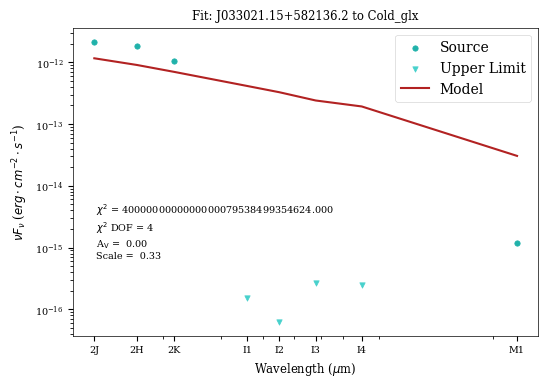

In [42]:
from astropy.visualization import quantity_support
quantity_support()

modelnum = 351

modellogfluxes = savables['Model Fluxes'][modelnum]
filterpeaks = [x for x in filterpeaks] * u.um
modelflux = 10**(modellogfluxes) * u.mJy
modelfluxdens = modelflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))
sourceflux =savables['Source Flux'][modelnum] 
sourceflux = sourceflux * u.mJy
sourcefluxdens = sourceflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))

sourceerror = savables['Source Error'][modelnum]
sourceerror = sourceerror * u.mJy
sourcerrordens = sourceerror.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))

mask = savables['Valid'][modelnum]

plt.figure(figsize=(6,4))
plt.scatter(filterpeaks[mask], sourcefluxdens[mask], c = 'lightseagreen',label = 'Source',s = 15) # Prints true values of the source
plt.scatter(filterpeaks[~mask], sourcefluxdens[~mask], c = 'mediumturquoise',label = 'Upper Limit', marker = 'v', s=15) # Prints upper limits of the source as triangles
plt.plot(filterpeaks, modelfluxdens,color='firebrick', label = 'Model')
plt.errorbar(filterpeaks[mask], sourcefluxdens[mask], yerr=sourcerrordens[mask],linestyle='', c='lightseagreen')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength ' + '($\mu$m)')
plt.ylabel('$\\nu F_{\\nu}$ ' + '($erg \cdot cm^{-2} \cdot s^{-1}$)')
plt.xticks(filterpeaks, ['2J', '2H', '2K', 'I1', 'I2', 'I3', 'I4', 'M1'])
plt.title('Fit: ' + savables['ID'][modelnum]+ ' to ' + savables['Model'][modelnum])
plt.text(0.05,0.25, "$\chi^2$ = %5.3f   \n$\chi^2$ DOF = %1.0f   \nA$_{\\rm V}$ = %5.2f   \nScale = %5.2f" % (savables['Chi^2'][modelnum], savables['Chi^2 DOF'][modelnum], savables['Av'][modelnum], savables['Scale'][modelnum]),
         transform=plt.gca().transAxes,size='x-small')
plt.legend(fontsize='10')


In [27]:
from astropy.io import fits 

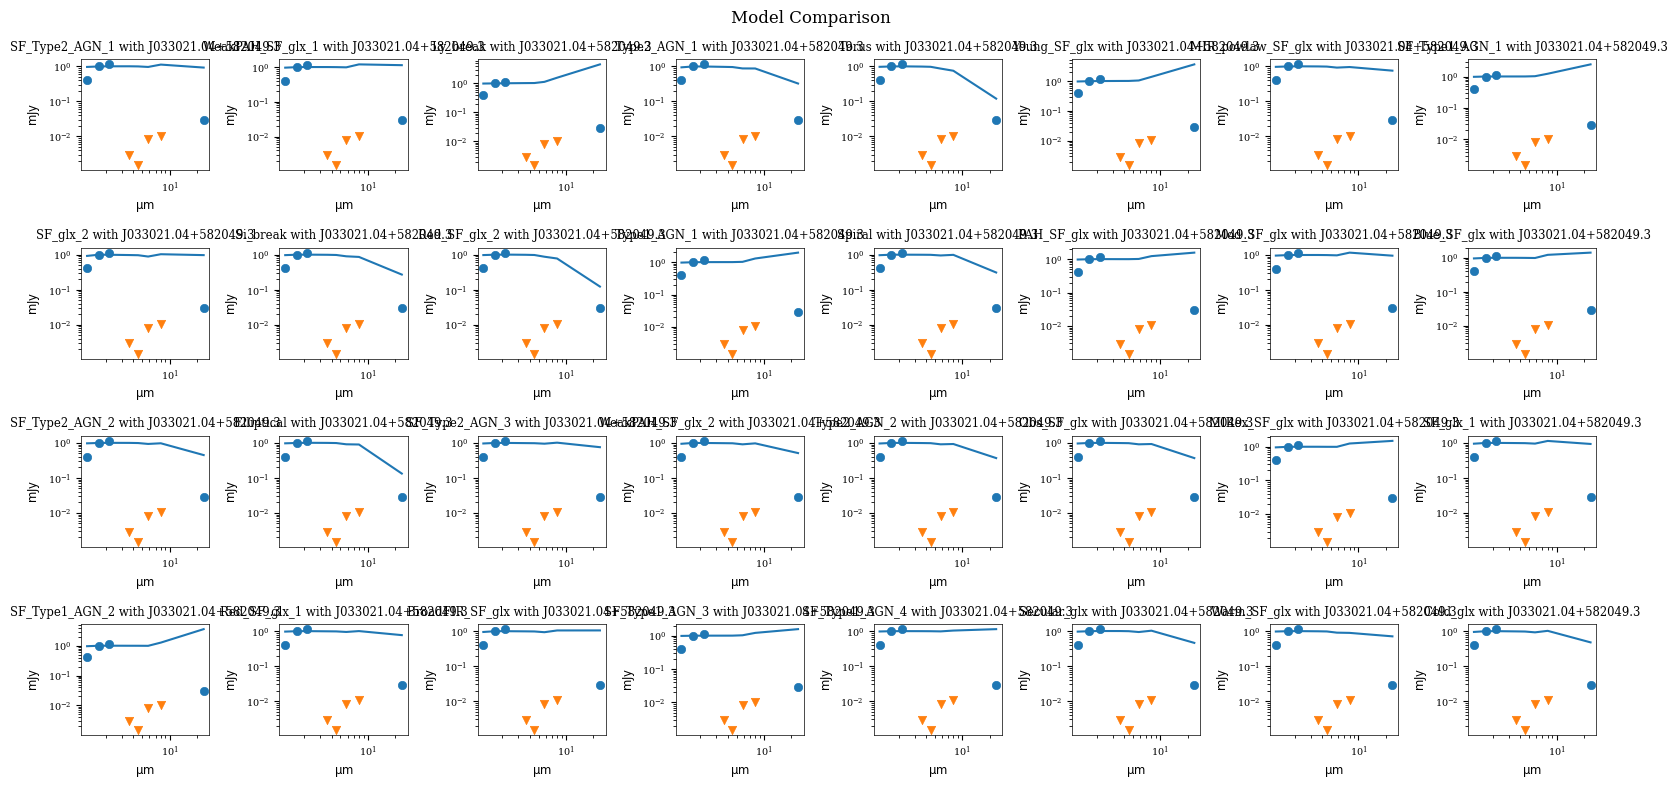

In [28]:
modelnum = 0

sourceflux = savables['Source Flux'][modelnum]
mask = savables['Valid'][modelnum]

    #convflux = retrieve_convolved_fluxes(model)
    #convflux = convflux / convflux[1] * u.mJy # normalize to H band
    #plt.figure()
    #plt.plot(filterpeaks,convflux)
    #plt.scatter(filterpeaks[mask],sourceflux[mask])
    #plt.scatter(filterpeaks[~mask],sourceflux[~mask],marker = 'v')
    #plt.title(model + ' with ' + savables['ID'][modelnum])
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Model Comparison')

for i, model in enumerate(models):
    convflux = retrieve_convolved_fluxes(model)
    convflux = convflux / convflux[1] * u.mJy # normalize to H band
    row = i // 8
    col = i % 8
    axs[row, col].plot(filterpeaks, convflux)
    axs[row, col].scatter(filterpeaks[mask], sourceflux[mask])
    axs[row, col].scatter(filterpeaks[~mask], sourceflux[~mask], marker='v')
    axs[row, col].set_title(model + ' with ' + savables['ID'][modelnum])
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')

plt.tight_layout()
plt.show()


In [26]:
def retrieve_convolved_fluxes(model):
    convolvedflux = []
    for filt in filters:
        with fits.open('../data/galaxySEDS/'+model+'/convolved/'+filt+'.fits') as hdul:
            data = hdul[1].data
            convolvedflux.append(data[0][1][0])
    return np.array(convolvedflux)

In [33]:
savables[savables['Chi^2 DOF']>=1].sort_values(by='Chi^2')

,ID,Model,Model Fluxes,Source Flux,Source Error,Valid,Chi^2,Chi^2 DOF,Av,Scale
228,J032551.69+582124.9,Torus,"[-0.2128190983399184, -0.20222226607942895, -0...","[0.904, 1.0, 3.387, 0.584, 0.68, 0.7147, 0.776...","[0.112, 0.1813, 1.0, 0.024, 1.0, 1.0, 1.0, 1.0]","[True, True, False, True, False, False, False,...",18.119517326028564,3,0.0,0.09178621453863539
254,J032551.69+582124.9,Warm_SF_glx,"[-0.2123935352974155, -0.20319701544573093, -0...","[0.904, 1.0, 3.387, 0.584, 0.68, 0.7147, 0.776...","[0.112, 0.1813, 1.0, 0.024, 1.0, 1.0, 1.0, 1.0]","[True, True, False, True, False, False, False,...",18.132930042244514,3,0.0,0.18001121189261568
249,J032551.69+582124.9,Red_SF_glx_1,"[-0.21366277599026245, -0.20231589936901612, -...","[0.904, 1.0, 3.387, 0.584, 0.68, 0.7147, 0.776...","[0.112, 0.1813, 1.0, 0.024, 1.0, 1.0, 1.0, 1.0]","[True, True, False, True, False, False, False,...",18.239548188181793,3,0.0,0.23298180234277985
234,J032551.69+582124.9,Red_SF_glx_2,"[-0.21372020536358616, -0.20304248773749134, -...","[0.904, 1.0, 3.387, 0.584, 0.68, 0.7147, 0.776...","[0.112, 0.1813, 1.0, 0.024, 1.0, 1.0, 1.0, 1.0]","[True, True, False, True, False, False, False,...",18.299743720689104,3,0.0,0.15470196825114618
227,J032551.69+582124.9,Type2_AGN_1,"[-0.21918883701439973, -0.19378119488831635, -...","[0.904, 1.0, 3.387, 0.584, 0.68, 0.7147, 0.776...","[0.112, 0.1813, 1.0, 0.024, 1.0, 1.0, 1.0, 1.0]","[True, True, False, True, False, False, False,...",18.39054715650374,3,0.0,0.18294127176342545
...,...,...,...,...,...,...,...,...,...,...
113,J032539.46+582059.2,Elliptical,"[-0.23415483788848213, -0.2232843215882807, -0...","[0.4471, 1.0, 1.081, 0.0001033, 0.00032, 0.000...","[0.008237, 0.01934, 0.01693, 1.0, 1.0, 1.0, 1....","[True, True, True, False, False, False, False,...",4e+30,4,0.0,0.2550650028198972
112,J032539.46+582059.2,SF_Type2_AGN_2,"[-0.32925017495853914, -0.31821635683281435, -...","[0.4471, 1.0, 1.081, 0.0001033, 0.00032, 0.000...","[0.008237, 0.01934, 0.01693, 1.0, 1.0, 1.0, 1....","[True, True, True, False, False, False, False,...",4e+30,4,0.0,0.25663810382238633
111,J032539.46+582059.2,Blue_SF_glx,"[-0.42350544282252667, -0.407641249383043, -0....","[0.4471, 1.0, 1.081, 0.0001033, 0.00032, 0.000...","[0.008237, 0.01934, 0.01693, 1.0, 1.0, 1.0, 1....","[True, True, True, False, False, False, False,...",4e+30,4,0.0,0.3908210483613366
350,J033021.15+582136.2,Warm_SF_glx,"[-0.33787587895922294, -0.32867935910753837, -...","[0.871, 1.0, 0.7613, 0.0001856, 9.439e-05, 0.0...","[0.01685, 0.02395, 0.01613, 1.0, 1.0, 1.0, 1.0...","[True, True, True, False, False, False, False,...",4e+30,4,0.0,0.2427523837235194


In [12]:
savables[savables['ID'] == 'J032637.84+582215.7'].loc[1247]['Source Error']

array([0.05807, 0.09348, 0.08924, 0.01416, 1.     , 1.     , 1.     ,
       1.     ])

In [144]:
# savables['Source Obj'][modelnum].flux
sourceflux = np.array(savables['Source Obj'][45].to_ascii().split()[11:-1:2]).astype(float)
sourceflux = sourceflux * u.mJy
sourcefluxdens = sourceflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))
print(sourcefluxdens[1])

1.803805403128761e-12 erg / (s cm2)


In [14]:
# Time to fit all of SESNA
3 * 5645590 / 60 / 60 / 24

196.02743055555558

In [15]:
6.5 / 10 * 5645590 / 60 / 60 / 24 # answer in days

42.4726099537037